In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import metrics 
import tqdm

import sys
# sys.path.insert(0, '')
import importlib
from dredFISH.Analysis import basicu

importlib.reload(basicu)

sns.set_context('talk')

# Load data

In [2]:
f = '../data_dump/candidate_genes_vincent_0328.csv'
df0 = pd.read_csv(f)
df0 = df0.sort_values(['Subclass', 'Type/Gradient'])
df0 = df0[df0['Gene']!='Neurod1']
df0 = df0.set_index('Gene')
df0

,Subclass,Type/Gradient,Function,Priority,Note
Gene,,,,,
Baz1a,L2/3,A<B>C,TF,***,NaN
Trpc6,L2/3,A<B>C,IC,***,NaN
Bdnf,L2/3,A<B>C,CAM,***,NaN
Sox5,L2/3,A<B>C,TF,NaN,NaN
Nrp1,L2/3,A<B>C,CAM,***,NaN
...,...,...,...,...,...
Ngb,L2/3,NaN,other,NaN,NaN
Penk,L2/3,NaN,other,NaN,NaN
Chrm2,"L2/3, L4",C>B=A,IC,***,NaN


In [3]:
%%time
adata = ad.read('../data_dump/P38_glut_genes_v2_annot.h5ad')
adata

CPU times: user 176 ms, sys: 685 ms, total: 861 ms
Wall time: 859 ms


AnnData object with n_obs × n_vars = 5837 × 86
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass', 'embed_1', 'embed_2', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18', 'PC_19', 'PC_20', 'PC_21', 'PC_22', 'PC_23', 'PC_24', 'PC_25', 'PC_26', 'PC_27', 'PC_28', 'PC_29', 'PC_30', 'PC_31', 'PC_32', 'PC_33', 'PC_34', 'PC_35', 'PC_36', 'PC_37', 'PC_38', 'PC_39', 'PC_40', 'PC_41', 'PC_42', 'PC_43', 'PC_44', 'PC_45', 'PC_46', 'PC_47', 'PC_48', 'PC_49', 'PC_50', 'PC_51', 'PC_52', 'PC_53', 'PC_54', 'PC_55', 'PC_56', 'PC_57', 'PC_58', 'PC_59', 'PC_60', 'PC_61', 'PC_62', 'PC_63', 'PC_64', 'PC_65', 'PC_66', 'PC_67', 'PC_68', 'PC_69', 'PC_70', 'PC_71', 'PC_72', 'PC_73', 'PC_74', 'PC_75', 'PC_76', 'PC_77', 'PC_78', 'PC_79', 'PC_80', 'PC_81', 'PC_82', 'PC_83', 'PC_84', 'PC_8

In [4]:
# ## classsification based off the ~86 genes (Try LASSO for the minimum set of genes)
# - L2/3 vs L4
# - L2/3 subtypes
# - continuum (UMAP_1 as a proxy)

In [5]:
def get_precision_recall(y_true, y_pred):
    """Auto system; has some edge case issues
    """
    p, r, th = metrics.precision_recall_curve(y_true, y_pred)
    # pidx = np.argsort(p)
    # p = p[pidx]
    # r = r[pidx]
    # p = np.hstack([0, p, 1])
    # r = np.hstack([1, r, 0])
    return p, r

def get_precision_recall_v2(y_true, y_pred):
    """Auto system; has some edge case issues
    """
    pth = np.linspace(0,1,101)
    p = []
    r = []
    for pth1 in pth:
        conf = metrics.confusion_matrix(y_true, y_pred>pth)
        tn, fp, fn, tp = conf.ravel()
        p1 = tp/(tp+fp)
        r1 = tp/(tp+fn)
        p.append(p1)
        r.append(r1)
    
    return p, r

def evaluate(y_true, y_pred, pr_opt='v1'):
    """
    """
    # evaluation
    if pr_opt == 'v1':
        p, r = get_precision_recall(y_true, y_pred)
    elif pr_opt == 'v2':
        p, r = get_precision_recall_v2(y_true, y_pred)
    aupr = metrics.auc(r, p)
    # aupr = -1
    return p, r, aupr

def classifier_pipe(X, y, c=1):
    """
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    ps = []
    rs = []
    auprs = []
    
    y_true = np.empty(len(y))
    y_pred = np.empty(len(y))
    
    
    l0s = []
    l1s = []
    for train_idx, test_idx, in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # train
        model = LogisticRegression(penalty='l1', solver='liblinear', C=c, random_state=0)
        # model = LogisticRegression(random_state=0)
        model.fit(X_train, y_train)
        
        # test
        yp = model.predict_proba(X_test)
        
        # results
        l0 = (np.abs(model.coef_) > 1e-6).sum() 
        l1 = np.abs(model.coef_).sum()
        l0s.append(l0)
        l1s.append(l1)
        
        # results
        y_true[test_idx] = y_test.values.astype(int)
        y_pred[test_idx] = yp[:,1]
        
        
    return y_true, y_pred, l0s, l1s

def plot_pipe(ax, y_true, y_pred, pr_opt='v1'):
    """
    """
    ps, rs, aupr = evaluate(y_true, y_pred, pr_opt=pr_opt) 
    
    ax.plot(rs, ps, color='C0', linewidth=2)
    ax.text(0,0.1, f"AUPR={aupr:.2f}")
    sns.despine(ax=ax)
    ax.set_aspect('equal')
    ax.set_xticks(np.linspace(0,1,6))
    ax.set_yticks(np.linspace(0,1,6))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    return ax

# L2/3 vs L4

In [6]:
# data
X = adata.X
y = adata.obs['cluster'].str.contains('L2/3')
print(X.shape, y.shape)

# run
y_true, y_pred, l0s, l1s = classifier_pipe(X, y, c=1)

(5837, 86) (5837,)


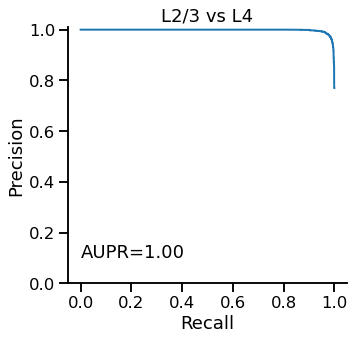

In [7]:
# vis
fig, ax = plt.subplots(1,1,figsize=(5*1,5))
plot_pipe(ax, y_true, y_pred, pr_opt='v1')
ax.set_title(f'L2/3 vs L4')
plt.show()

# L2/3 vs L4 - tune parameters

In [8]:
def classifier_tuning(X, y, Cs):
    """
    """
    res = []
    ressum = []
    for c in tqdm.tqdm(Cs):
        # run
        y_true, y_pred, l0s, l1s = classifier_pipe(X, y, c=c)
        p, r, aupr = evaluate(y_true, y_pred)
        res.append((y_true, y_pred, l0s, l1s))
        ressum.append({
           'C': c,
           'AUPR': aupr,
           'coef L0': np.mean(l0s),
           'coef L1': np.mean(l1s),
          })

    ressum = pd.DataFrame(ressum)
    return res, ressum

def plot_ressum(ressum, scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    ax.plot(ressum['C'], ressum['coef L0'], '-o')
    ax.set_ylabel('# genes used')
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    ax.set_title(title)
    
    ax = axs[1]
    ax.plot(ressum['C'], ressum['AUPR'], '-o')
    ax.set_ylabel('AUPR')
    ax.set_xlabel('Regularization')
    ax.set_ylim(ymax=1.02)
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    if scale == 'linear':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()
    
def plot_res(res, Cs, suptitle=''):
    """
    """
    n = len(Cs)
    nx = 5
    ny = int((n+nx-1)/nx)

    fig, axs = plt.subplots(ny,nx,figsize=(5*nx,5*ny))
    for i, (oneres, c, ax) in enumerate(zip(res, Cs, axs.flat)):
        y_true, y_pred, _, _ = oneres
        plot_pipe(ax, y_true, y_pred, pr_opt='v1')
        ax.set_title(f'C = {c:.2g}')

    for ax in axs.flat[i+1:]:
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.suptitle(suptitle, fontsize=20)
    plt.show()

In [9]:
# data
X = adata.X
y = adata.obs['cluster'].str.contains('L2/3')
print(X.shape, y.shape)

(5837, 86) (5837,)


In [10]:
# Cs = np.linspace(4e-4, 5e-4, 11) # micro
# Cs = np.logspace(-4, 1, 6) # macro
Cs = np.linspace(1e-4, 1e-3, 10) # macro
res, ressum = classifier_tuning(X, y, Cs)

100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


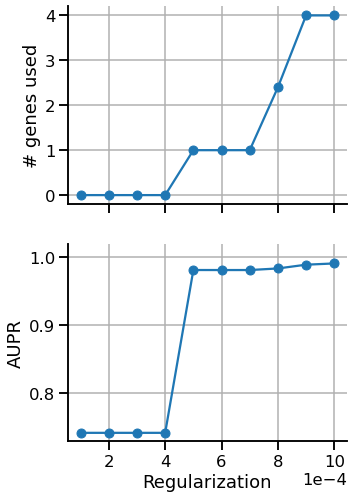

In [11]:
plot_ressum(ressum, scale='linear')

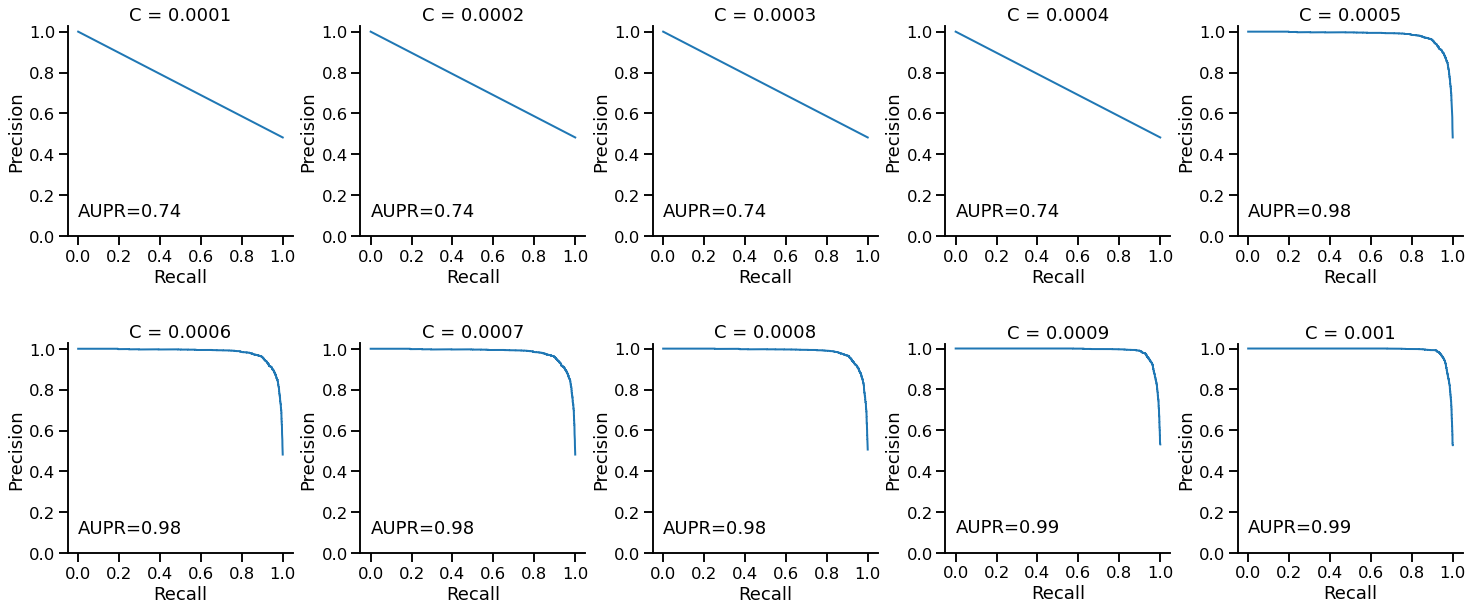

In [12]:
plot_res(res, Cs)

In [13]:
def get_model_used_genes(model, allgenes):
    """
    """
    abscoef = np.abs(model.coef_.reshape(-1,))
    cond = abscoef > 1e-6 
    
    if cond.sum() > 0:
        used_abscoef = abscoef[cond]
        used_genes = allgenes[cond]
        used_coefidx = np.argsort(used_abscoef)[::-1]

        return used_abscoef[used_coefidx], used_genes[used_coefidx]
    else:
        return 0,0

In [14]:
# c = 5e-4
allgenes = adata.var.index.values
for c in Cs:
    # which gene?
    model = LogisticRegression(penalty='l1', solver='liblinear', C=c, random_state=0)
    model.fit(X, y)
    absweights, ugenes = get_model_used_genes(model, allgenes)
    print(c, absweights, ugenes)

0.0001 0 0
0.00019999999999999998 0 0
0.0003 0 0
0.00039999999999999996 [0.15123997] ['Gria3']
0.0005 [0.41203704] ['Gria3']
0.0006000000000000001 [0.60789791] ['Gria3']
0.0007 [0.68209469 0.06779675 0.04372197 0.01998521] ['Gria3' 'Chrm3' 'Dgkb' 'Ncam2']
0.0007999999999999999 [0.72030262 0.13408449 0.09146193 0.05444027] ['Gria3' 'Chrm3' 'Dgkb' 'Ncam2']
0.0009 [0.75534222 0.19104789 0.13130636 0.08174511] ['Gria3' 'Chrm3' 'Dgkb' 'Ncam2']
0.001 [0.78910552 0.24077043 0.1638342  0.10520481] ['Gria3' 'Chrm3' 'Dgkb' 'Ncam2']


In [15]:
selected_c = 0.001
allgenes = adata.var.index.values
model = LogisticRegression(penalty='l1', solver='liblinear', C=selected_c, random_state=0)
model.fit(X, y)
absweights, ugenes = get_model_used_genes(model, allgenes)
print(c, absweights, ugenes)


0.001 [0.78910552 0.24077043 0.1638342  0.10520481] ['Gria3' 'Chrm3' 'Dgkb' 'Ncam2']


In [16]:
Xk, xclsts = basicu.group_mean(X, adata.obs['cluster'])
Xk = np.array(Xk)
Xk = pd.DataFrame(Xk, index=xclsts, columns=allgenes)
Xk.shape, xclsts.shape, xclsts

((6, 86),
 (6,),
 array(['L2/3_A', 'L2/3_B', 'L2/3_C', 'L4_A', 'L4_B', 'L4_C'], dtype=object))

In [17]:
Xplot = Xk.T.loc[ugenes] #[gene_order].T
# mat, rows, cols = basicu.diag_matrix_rows(Xplot.values)
# Xplot = pd.DataFrame(mat, index=Xplot.index.values[rows], columns=Xplot.columns.values[cols])
Xannot = df0.loc[Xplot.index][['Subclass', 'Type/Gradient', 'Function', 'Priority']].fillna('')

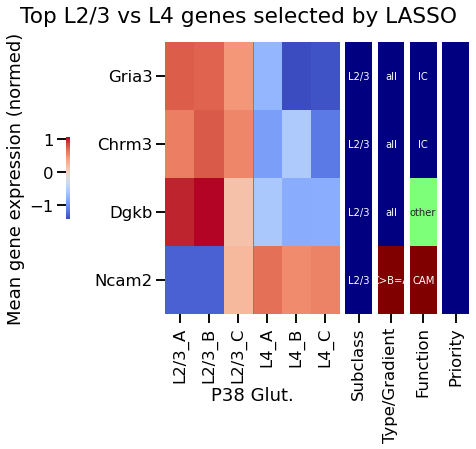

In [18]:
mosaic = "A"*10+"BCDE"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8,5))
ax = axs['A']
sns.heatmap(Xplot, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            cbar_kws=dict(shrink=0.3, label='Mean gene expression (normed)', location='left', pad=0.3),
            ax=ax)
ax.axvline(3, color='gray', linewidth=1)
ax.set_yticklabels(ax.get_yticklabels(), 
                   # fontsize=10, 
                   rotation=0)
ax.set_xlabel('P38 Glut.')

for i, ax in enumerate([axs['B'], axs['C'], axs['D'], axs['E']]):
    nums, catgs = pd.factorize(Xannot.iloc[:,i])
    # ax.set_title(Xannot.columns[i], fontsize=12, rotation=90)
    sns.heatmap(nums.reshape(-1,1), 
                annot=pd.Series(catgs.values[nums]).values.reshape(-1,1),
                annot_kws={'size': 10},
                yticklabels=False,
                # xticklabels=False,
                fmt='',
                cbar=False,
                cmap='jet',
                ax=ax
               )
    ax.set_xticklabels([Xannot.columns[i]], rotation=90)
fig.suptitle("Top L2/3 vs L4 genes selected by LASSO")
plt.show()

# L2/3

In [19]:
# data
cond = adata.obs['cluster'].str.contains('L2/3')
adatasub = adata[cond].copy()
X = adatasub.X

y_a = adatasub.obs['cluster'].str.contains('L2/3_A') 
y_b = adatasub.obs['cluster'].str.contains('L2/3_B') 
y_c = adatasub.obs['cluster'].str.contains('L2/3_C') 
print(X.shape, y_a.shape, y_b.shape, y_c.shape)

(2818, 86) (2818,) (2818,) (2818,)


# L2/3 A 

In [20]:
Cs = np.logspace(-4, 0, 20) # macro
print(Cs)
res_a, ressum_a = classifier_tuning(X, y_a, Cs)

[1.00000000e-04 1.62377674e-04 2.63665090e-04 4.28133240e-04
 6.95192796e-04 1.12883789e-03 1.83298071e-03 2.97635144e-03
 4.83293024e-03 7.84759970e-03 1.27427499e-02 2.06913808e-02
 3.35981829e-02 5.45559478e-02 8.85866790e-02 1.43844989e-01
 2.33572147e-01 3.79269019e-01 6.15848211e-01 1.00000000e+00]


100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


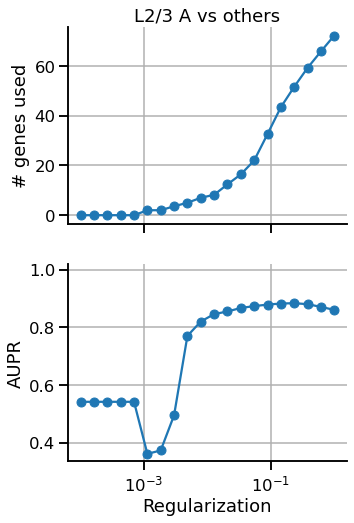

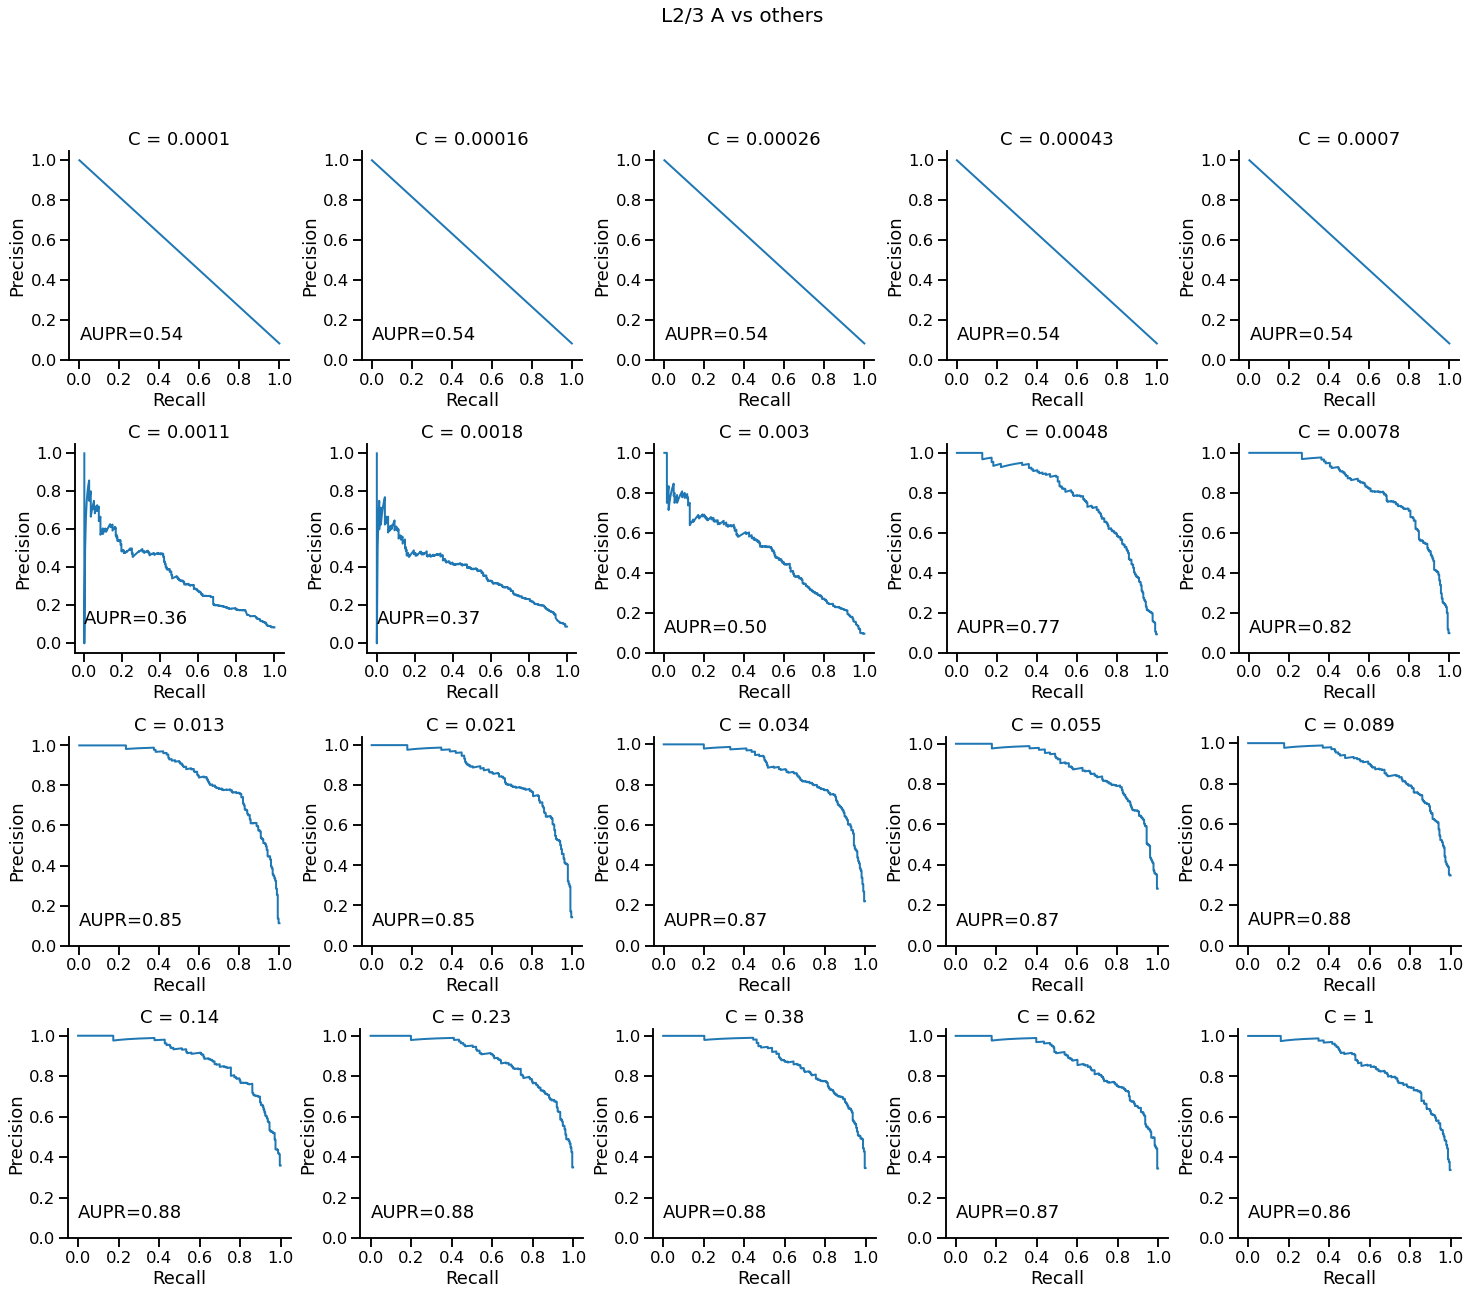

In [21]:
# plot_ressum(ressum, scale='linear')
title = 'L2/3 A vs others'
plot_ressum(ressum_a, scale='log', title=title)
plot_res(res_a, Cs, suptitle=title)

In [22]:
selected_c = 0.04
allgenes = adata.var.index.values
model = LogisticRegression(penalty='l1', solver='liblinear', C=selected_c, random_state=0)
model.fit(X, y_a)
absweights, ugenes = get_model_used_genes(model, allgenes)
print(c, len(ugenes), absweights, ugenes)


0.001 21 [0.73940487 0.66403692 0.55464718 0.42151191 0.32043887 0.18376898
 0.17992303 0.15818472 0.12460167 0.12402343 0.11175973 0.07761173
 0.07401739 0.06575897 0.05451651 0.02827839 0.02325866 0.01901836
 0.00961325 0.00874502 0.00816224] ['Cdh13' 'Cdh12' 'Cntn5' 'Sorcs3' 'Adamts2' 'Kcnq5' 'Nr4a3' 'Igfn1'
 'Stard8' 'Epha10' 'Mkx' 'Trpc6' 'Kcnh5' 'Cbln2' 'Kcnn3' 'Fst' 'Tenm1'
 'Robo1' 'Baz1a' 'Met' 'Ptpru']


In [23]:
Xk, xclsts = basicu.group_mean(X, adatasub.obs['cluster'])
Xk = np.array(Xk)
Xk = pd.DataFrame(Xk, index=xclsts, columns=allgenes)
Xk.shape, xclsts.shape, xclsts

((3, 86), (3,), array(['L2/3_A', 'L2/3_B', 'L2/3_C'], dtype=object))

In [24]:
Xplot = Xk.T.loc[ugenes]
Xannot = df0.loc[Xplot.index][['Subclass', 'Type/Gradient', 'Function', 'Priority']].fillna('')

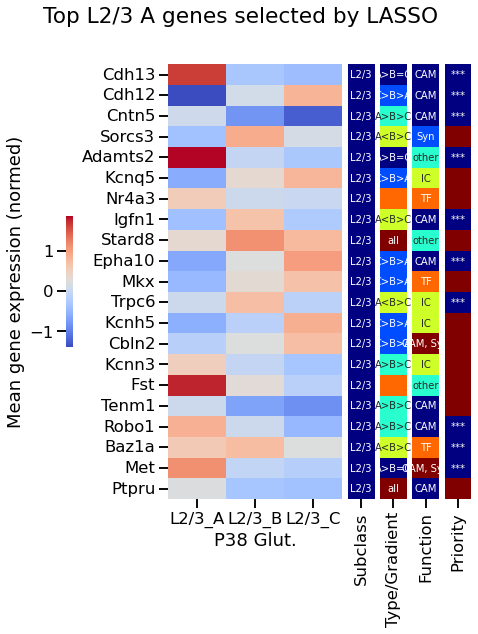

In [25]:
mosaic = "A"*10+"BCDE"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8,8))
ax = axs['A']
sns.heatmap(Xplot, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            cbar_kws=dict(shrink=0.3, label='Mean gene expression (normed)', location='left', pad=0.3),
            ax=ax)
ax.axvline(3, color='gray', linewidth=1)
ax.set_yticklabels(ax.get_yticklabels(), 
                   # fontsize=10, 
                   rotation=0)
ax.set_xlabel('P38 Glut.')

for i, ax in enumerate([axs['B'], axs['C'], axs['D'], axs['E']]):
    nums, catgs = pd.factorize(Xannot.iloc[:,i])
    # ax.set_title(Xannot.columns[i], fontsize=12, rotation=90)
    sns.heatmap(nums.reshape(-1,1), 
                annot=pd.Series(catgs.values[nums]).values.reshape(-1,1),
                annot_kws={'size': 10},
                yticklabels=False,
                # xticklabels=False,
                fmt='',
                cbar=False,
                cmap='jet',
                ax=ax
               )
    ax.set_xticklabels([Xannot.columns[i]], rotation=90)
fig.suptitle("Top L2/3 A genes selected by LASSO")
plt.show()

# L2/3 B 

In [26]:
Cs = np.logspace(-4, 0, 21) # macro
print(Cs)
res_b, ressum_b = classifier_tuning(X, y_b, Cs)


[1.00000000e-04 1.58489319e-04 2.51188643e-04 3.98107171e-04
 6.30957344e-04 1.00000000e-03 1.58489319e-03 2.51188643e-03
 3.98107171e-03 6.30957344e-03 1.00000000e-02 1.58489319e-02
 2.51188643e-02 3.98107171e-02 6.30957344e-02 1.00000000e-01
 1.58489319e-01 2.51188643e-01 3.98107171e-01 6.30957344e-01
 1.00000000e+00]


100%|██████████| 21/21 [00:01<00:00, 11.97it/s]


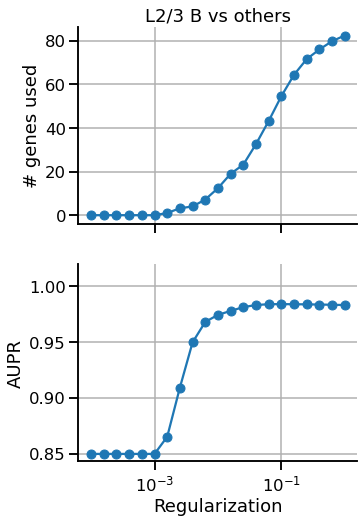

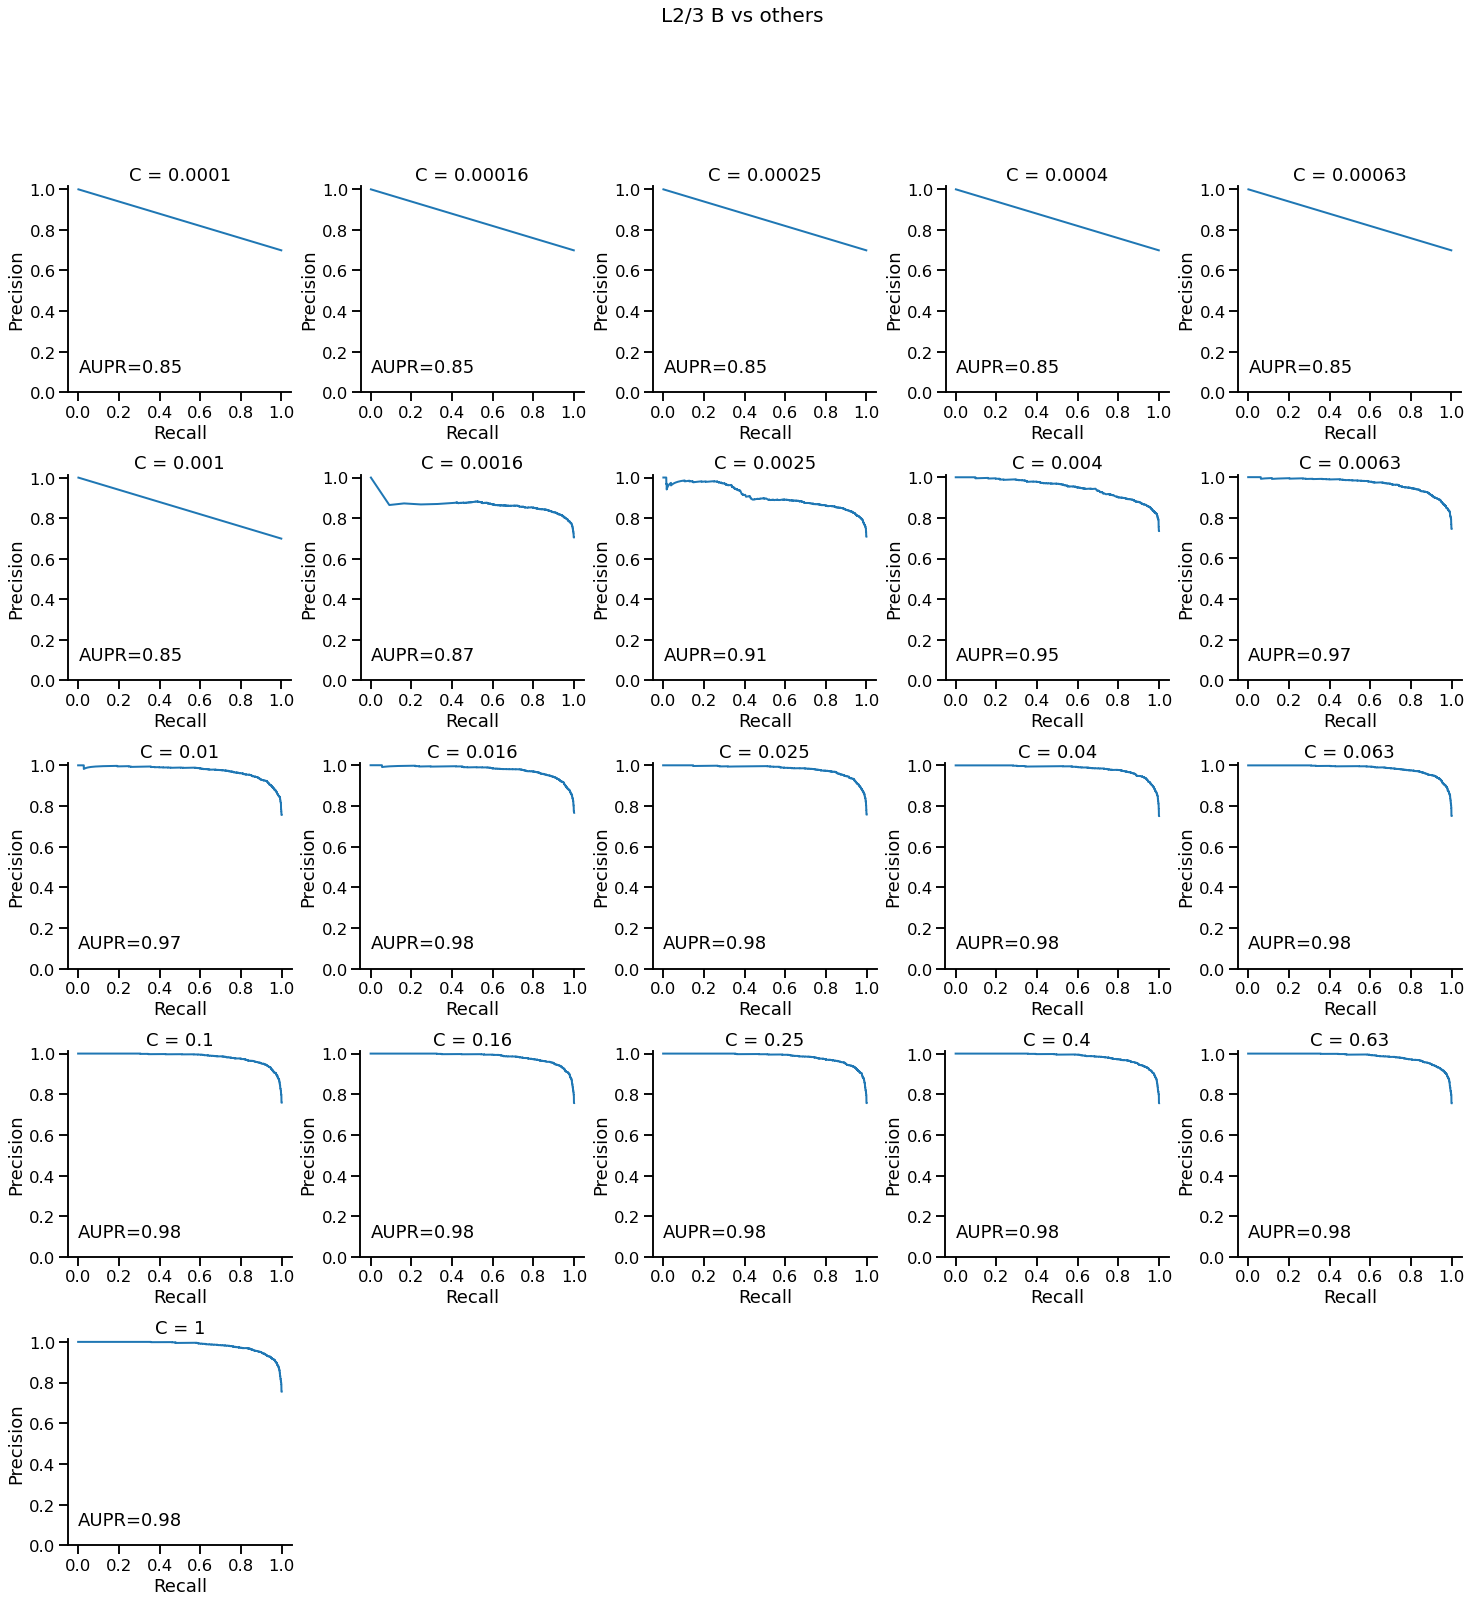

In [27]:
title = 'L2/3 B vs others'
plot_ressum(ressum_b, scale='log', title=title)
plot_res(res_b, Cs, suptitle=title)

In [28]:
selected_c = 0.02
allgenes = adata.var.index.values
model = LogisticRegression(penalty='l1', solver='liblinear', C=selected_c, random_state=0)
model.fit(X, y_b)
absweights, ugenes = get_model_used_genes(model, allgenes)
print(c, len(ugenes), absweights, ugenes)

0.001 22 [0.82028952 0.78245884 0.442525   0.40565408 0.37276156 0.33625554
 0.29142572 0.22935304 0.21186073 0.19708548 0.19588907 0.17204319
 0.16855667 0.11050752 0.10241661 0.08978417 0.06911582 0.06188946
 0.04942794 0.02963351 0.02530976 0.01943542] ['Chrm2' 'Cdh13' 'Sorcs3' 'Ncam2' 'Rorb' 'Kcnip3' 'Gabrg3' 'Igfn1' 'Sox5'
 'Dgkb' 'Cntnap2' 'Pcdh15' 'Grm8' 'Adamts2' 'Cdh12' 'Pld5' 'Gpc6' 'Trpc6'
 'Egfem1' 'Stard8' 'Fst' 'Epha3']


In [29]:
Xk, xclsts = basicu.group_mean(X, adatasub.obs['cluster'])
Xk = np.array(Xk)
Xk = pd.DataFrame(Xk, index=xclsts, columns=allgenes)
Xk.shape, xclsts.shape, xclsts

((3, 86), (3,), array(['L2/3_A', 'L2/3_B', 'L2/3_C'], dtype=object))

In [30]:
Xplot = Xk.T.loc[ugenes] 
Xannot = df0.loc[Xplot.index][['Subclass', 'Type/Gradient', 'Function', 'Priority']].fillna('')

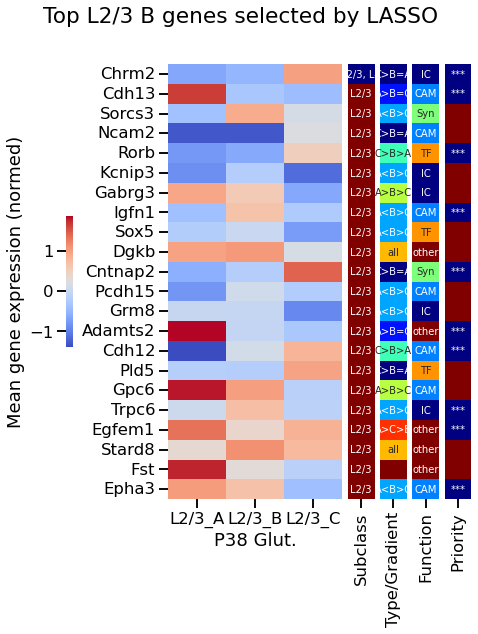

In [31]:
mosaic = "A"*10+"BCDE"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8,8))
ax = axs['A']
sns.heatmap(Xplot, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            cbar_kws=dict(shrink=0.3, label='Mean gene expression (normed)', location='left', pad=0.3),
            ax=ax)
ax.axvline(3, color='gray', linewidth=1)
ax.set_yticklabels(ax.get_yticklabels(), 
                   # fontsize=10, 
                   rotation=0)
ax.set_xlabel('P38 Glut.')

for i, ax in enumerate([axs['B'], axs['C'], axs['D'], axs['E']]):
    nums, catgs = pd.factorize(Xannot.iloc[:,i])
    # ax.set_title(Xannot.columns[i], fontsize=12, rotation=90)
    sns.heatmap(nums.reshape(-1,1), 
                annot=pd.Series(catgs.values[nums]).values.reshape(-1,1),
                annot_kws={'size': 10},
                yticklabels=False,
                # xticklabels=False,
                fmt='',
                cbar=False,
                cmap='jet',
                ax=ax
               )
    ax.set_xticklabels([Xannot.columns[i]], rotation=90)
fig.suptitle("Top L2/3 B genes selected by LASSO")
plt.show()

# L2/3 C 

In [32]:
Cs = np.logspace(-4, 0, 21) # macro
print(Cs)
res_c, ressum_c = classifier_tuning(X, y_c, Cs)


[1.00000000e-04 1.58489319e-04 2.51188643e-04 3.98107171e-04
 6.30957344e-04 1.00000000e-03 1.58489319e-03 2.51188643e-03
 3.98107171e-03 6.30957344e-03 1.00000000e-02 1.58489319e-02
 2.51188643e-02 3.98107171e-02 6.30957344e-02 1.00000000e-01
 1.58489319e-01 2.51188643e-01 3.98107171e-01 6.30957344e-01
 1.00000000e+00]


100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


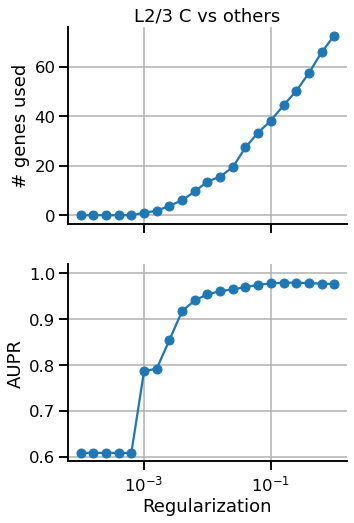

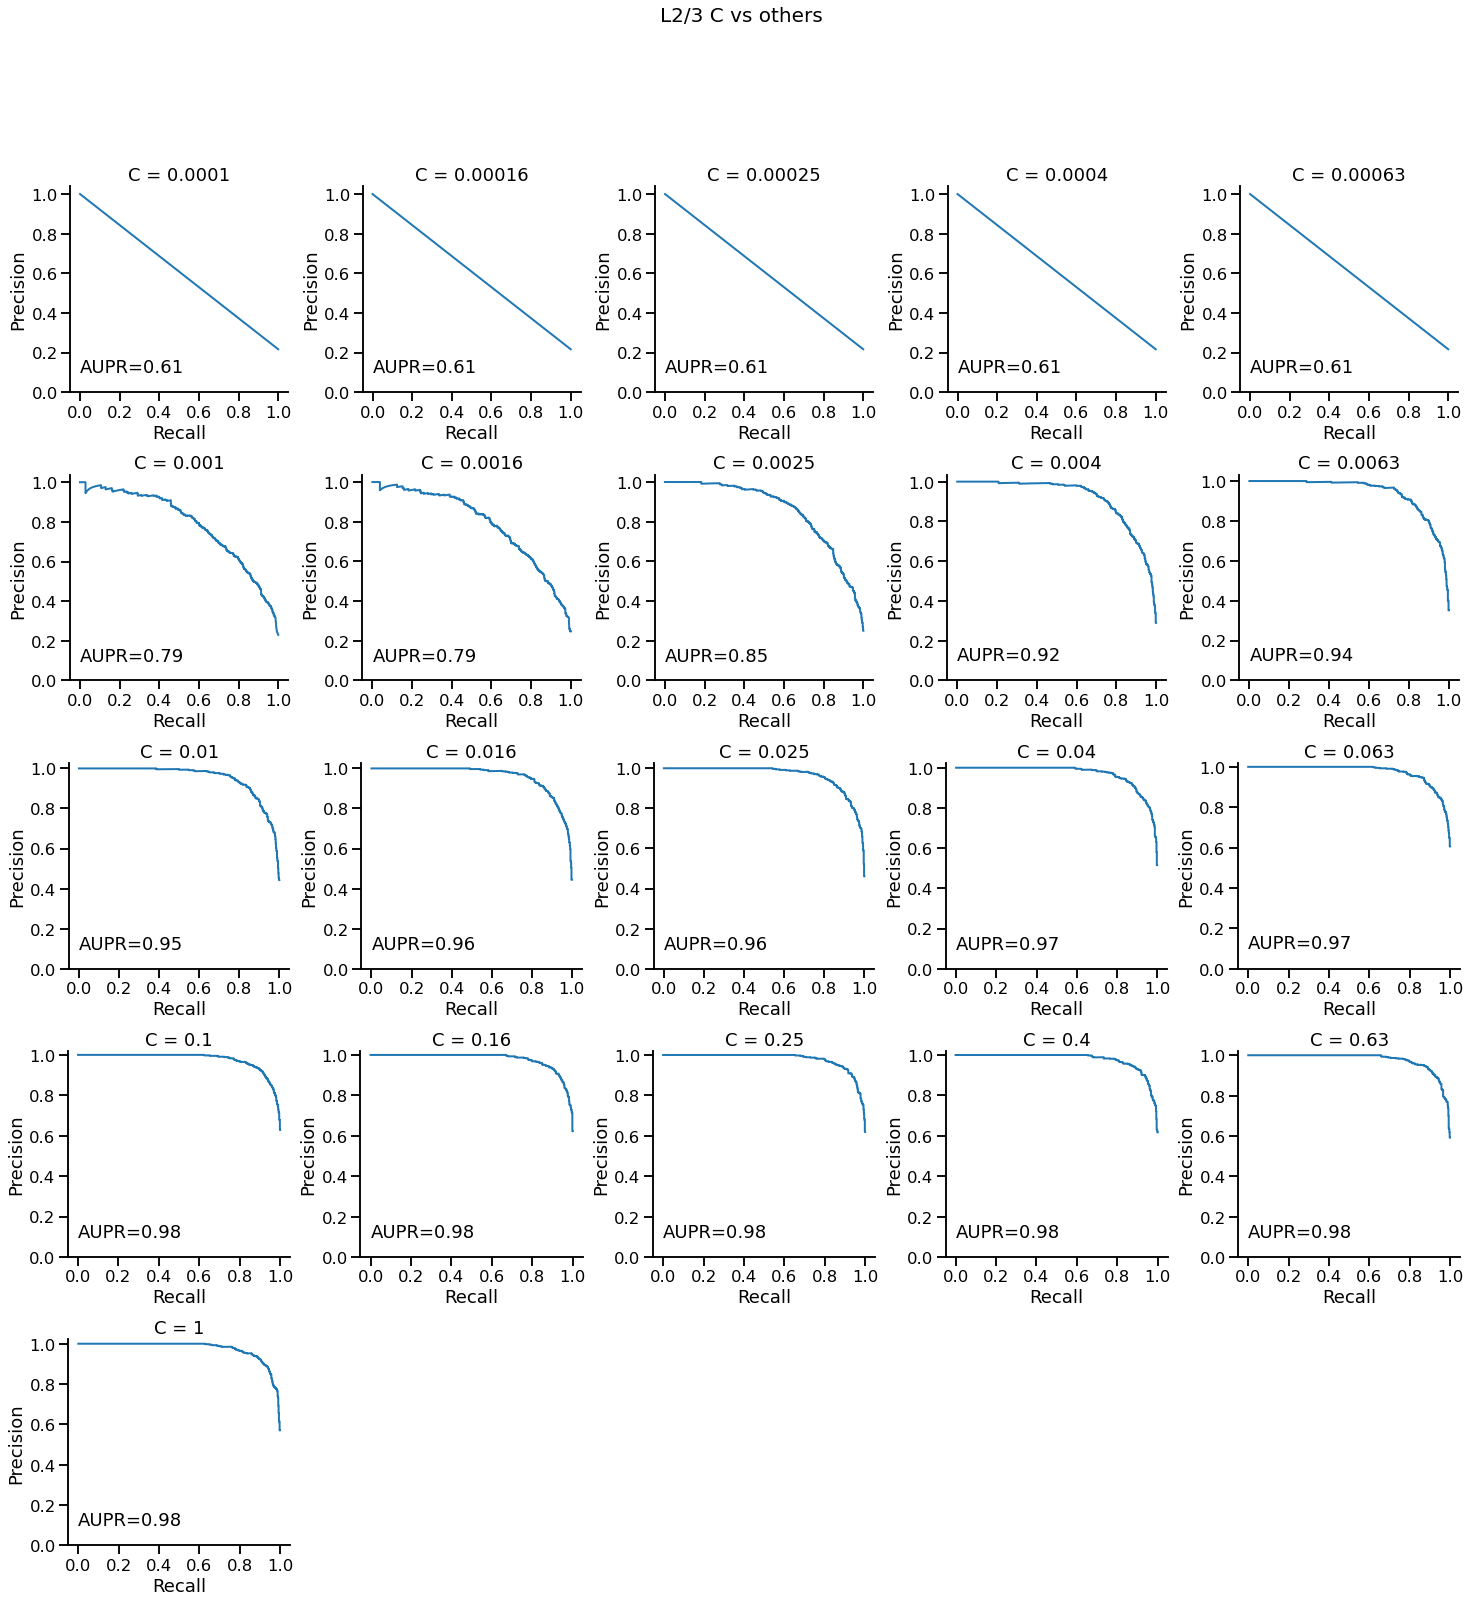

In [33]:
title = 'L2/3 C vs others'
plot_ressum(ressum_c, scale='log', title=title)
plot_res(res_c, Cs, suptitle=title)

In [34]:
selected_c = 0.02
allgenes = adata.var.index.values
model = LogisticRegression(penalty='l1', solver='liblinear', C=selected_c, random_state=0)
model.fit(X, y_c)
absweights, ugenes = get_model_used_genes(model, allgenes)
print(c, len(ugenes), absweights, ugenes)

0.001 19 [0.79192976 0.73731547 0.60384274 0.45239422 0.43362829 0.42728683
 0.23397077 0.21483445 0.12879988 0.10611256 0.09597347 0.09314939
 0.08559957 0.05948394 0.05892995 0.05297931 0.03365219 0.02867638
 0.01085694] ['Ncam2' 'Chrm2' 'Cntnap2' 'Gabrg3' 'Rorb' 'Gpc6' 'Sorcs3' 'Grm1' 'Foxp1'
 'Igfn1' 'Igsf11' 'Rfx3' 'Epha3' 'Grik3' 'Dgkb' 'Otof' 'Ccbe1' 'Kcnip3'
 'Grm8']


In [35]:
Xk, xclsts = basicu.group_mean(X, adatasub.obs['cluster'])
Xk = np.array(Xk)
Xk = pd.DataFrame(Xk, index=xclsts, columns=allgenes)
Xk.shape, xclsts.shape, xclsts

((3, 86), (3,), array(['L2/3_A', 'L2/3_B', 'L2/3_C'], dtype=object))

In [36]:
Xplot = Xk.T.loc[ugenes] 
Xannot = df0.loc[Xplot.index][['Subclass', 'Type/Gradient', 'Function', 'Priority']].fillna('')

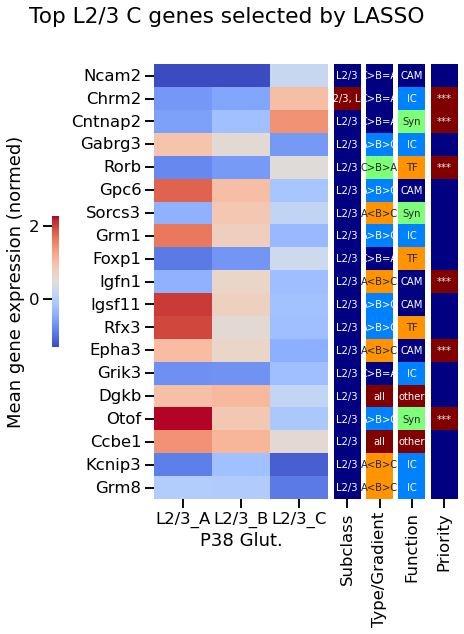

In [37]:
mosaic = "A"*10+"BCDE"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8,8))
ax = axs['A']
sns.heatmap(Xplot, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            cbar_kws=dict(shrink=0.3, label='Mean gene expression (normed)', location='left', pad=0.3),
            ax=ax)
ax.axvline(3, color='gray', linewidth=1)
ax.set_yticklabels(ax.get_yticklabels(), 
                   # fontsize=10, 
                   rotation=0)
ax.set_xlabel('P38 Glut.')

for i, ax in enumerate([axs['B'], axs['C'], axs['D'], axs['E']]):
    nums, catgs = pd.factorize(Xannot.iloc[:,i])
    # ax.set_title(Xannot.columns[i], fontsize=12, rotation=90)
    sns.heatmap(nums.reshape(-1,1), 
                annot=pd.Series(catgs.values[nums]).values.reshape(-1,1),
                annot_kws={'size': 10},
                yticklabels=False,
                # xticklabels=False,
                fmt='',
                cbar=False,
                cmap='jet',
                ax=ax
               )
    ax.set_xticklabels([Xannot.columns[i]], rotation=90)
fig.suptitle("Top L2/3 C genes selected by LASSO")
plt.show()